In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download akash2sharma/tiny-imagenet/
!pip install fvcore

Dataset URL: https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet/versions/
License(s): unknown
 97% 458M/474M [00:03<00:00, 187MB/s]
100% 474M/474M [00:03<00:00, 143MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=1fbfd2729ceeef3263cfb2af3e3151d32d3d26f514633f7c5ba77545efca016f
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=d8f85842cd5ec1159ba4ed6e8a5b71d288097cb408956c3f01382caceda9ff00
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [2]:
import numpy as np
import pandas as pd
import time
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.optim as optim
import zipfile
import os

from tqdm import tqdm
from torchvision import datasets, transforms
from torchvision.transforms import functional as F, ToPILImage
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split, Subset
from torch.utils.tensorboard import SummaryWriter
from einops import rearrange
from einops.layers.torch import Rearrange
from fvcore.nn import FlopCountAnalysis

In [3]:
zip_file_path = "tiny-imagenet.zip"
extract_dir = "tiny-imagenet"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to: {os.path.abspath(extract_dir)}")

Extracted to: /content/tiny-imagenet


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    print(f"Using GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("Using CPU")

Using GPU: Tesla T4


In [5]:
train_dir = "/content/tiny-imagenet/tiny-imagenet-200/train"
val_dir = "/content/tiny-imagenet/tiny-imagenet-200/val"
test_dir = "/content/tiny-imagenet/tiny-imagenet-200/test"

batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
train_loaders = [train_loader]

val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
val_loaders = [val_loader]

test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loaders = [test_loader]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


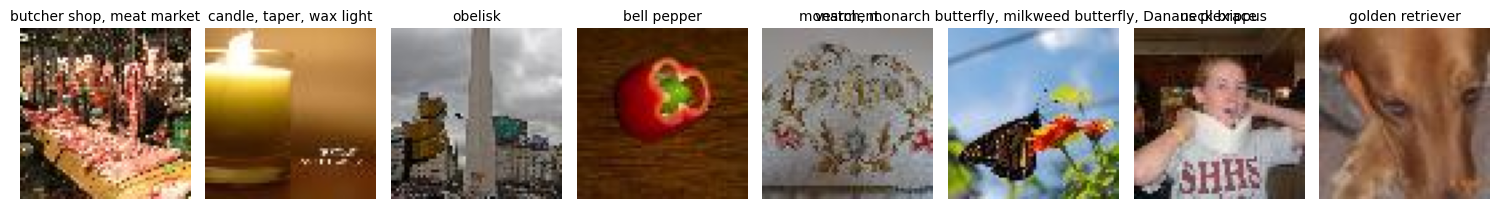

In [6]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title, fontsize=10)
    plt.show()


def visualize_train_loader(train_loader, classes, num_images=8):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    images = images[:num_images]
    labels = labels[:num_images]

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(5, num_images, i + 1)
        img = ToPILImage()(images[i])
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{classes[labels[i]]}", fontsize=10)

    plt.tight_layout()
    plt.show()

classes = train_dataset.classes
words_df = pd.read_csv("/content/tiny-imagenet/tiny-imagenet-200/words.txt", header=None, delimiter='\t', names=["folder", "label"])
labels = [words_df[words_df['folder']==classes[i]]['label'].iloc[0] for i in range(200)]

visualize_train_loader(train_loader, labels)

In [7]:
######################## Coatnet #########################


def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)

        if self.downsample:
            self.pool = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return x + self.conv(x)


class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        if self.downsample:
            self.pool1 = nn.MaxPool2d(3, 2, 1)
            self.pool2 = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = x + self.attn(x)
        x = x + self.ff(x)
        return x


class CoAtNet(nn.Module):
    def __init__(self, image_size, in_channels, num_blocks, channels, num_classes=1000, block_types=['C', 'C', 'T', 'T']):
        super().__init__()
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 2, iw // 2))
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 4, iw // 4))
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 8, iw // 8))
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 16, iw // 16))
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 32, iw // 32))

        self.pool = nn.AvgPool2d(ih // 32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=True))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)


def coatnet_0():
    num_blocks = [2, 2, 3, 5, 2]            # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((64, 64), 3, num_blocks, channels, num_classes=1000)


def coatnet_1():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((64, 64), 3, num_blocks, channels, num_classes=1000)


def coatnet_2():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [128, 128, 256, 512, 1026]   # D
    return CoAtNet((64, 64), 3, num_blocks, channels, num_classes=1000)


def coatnet_3():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((64, 64), 3, num_blocks, channels, num_classes=1000)


def coatnet_4():
    num_blocks = [2, 2, 12, 28, 2]          # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((64, 64), 3, num_blocks, channels, num_classes=1000)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


if __name__ == '__main__':
    img = torch.randn(1, 3, 64, 64)

    net = coatnet_0()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_1()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_2()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_3()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_4()
    out = net(img)
    print(out.shape, count_parameters(net))


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 1000]) 17759864
torch.Size([1, 1000]) 33091904
torch.Size([1, 1000]) 55688844
torch.Size([1, 1000]) 117645760
torch.Size([1, 1000]) 203805488


In [8]:
num_classes = 200

model = coatnet_3()
model.num_classes = num_classes

# Sesuaikan dengan ukuran gambar dataset 64 or 224
x = torch.randn(batch_size, 3, 64, 64)

model = model.to(device)
x = x.to(device)
output = model(x)

print(output.shape)
print(model)

torch.Size([1, 1000])
CoAtNet(
  (s0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
  )
  (s1): Sequential(
    (0): MBConv(
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (proj): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv): PreNorm(
        (norm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (fn): Sequential(
          (0): Conv2d(192, 768, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d

In [10]:
print(inputs.shape)


torch.Size([16, 3, 64, 64])


In [9]:
num_epochs = 1
lr_val = 0.001
patience = 2

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr_val, betas=(0.9, 0.999), weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

best_model_path = 'best_coatnet_model.pth'
best_val_loss = float('inf')
counter = 0

train_losses, train_acc, val_losses, val_acc = [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loader_tqdm = tqdm(train_loader, desc="Train Progress", leave=True)

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_train += predicted.eq(labels).sum().item()
        total_train += labels.size(0)

        train_loader_tqdm.set_postfix(loss=loss.item())

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_loader_tqdm = tqdm(val_loader, desc="Validation Progress", leave=True)

    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

            val_loader_tqdm.set_postfix(loss=loss.item())

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct_val / total_val

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Validation loss improved. Saving model to {best_model_path}.")
    else:
        counter += 1
        print(f"No improvement in validation loss. Counter: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            break

model.load_state_dict(torch.load(best_model_path))
print(f"Training complete. Best model loaded from {best_model_path}.")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/10


Validation Progress: 100%|██████████| 157/157 [00:17<00:00,  8.86it/s, loss=10.3]


Train Loss: 5.4206, Train Acc: 5.49%, Val Loss: 9.8672, Val Acc: 0.13%
Validation loss improved. Saving model to best_coatnet_model.pth.

Epoch 2/10


Validation Progress: 100%|██████████| 157/157 [00:17<00:00,  9.07it/s, loss=13.6]


Train Loss: 40.1558, Train Acc: 3.01%, Val Loss: 14.6165, Val Acc: 0.00%
No improvement in validation loss. Counter: 1/10

Epoch 3/10


Validation Progress: 100%|██████████| 157/157 [00:17<00:00,  8.87it/s, loss=6.68]


Train Loss: 5.4712, Train Acc: 5.03%, Val Loss: 7.2590, Val Acc: 1.44%
Validation loss improved. Saving model to best_coatnet_model.pth.

Epoch 4/10


Validation Progress: 100%|██████████| 157/157 [00:17<00:00,  9.00it/s, loss=12.9]


Train Loss: 4.7668, Train Acc: 8.53%, Val Loss: 12.4840, Val Acc: 0.05%
No improvement in validation loss. Counter: 1/10

Epoch 5/10


Validation Progress: 100%|██████████| 157/157 [00:17<00:00,  9.06it/s, loss=6.47]


Train Loss: 4.3750, Train Acc: 12.17%, Val Loss: 7.2196, Val Acc: 0.73%
Validation loss improved. Saving model to best_coatnet_model.pth.

Epoch 6/10


Validation Progress: 100%|██████████| 157/157 [00:17<00:00,  8.93it/s, loss=11.4]


Train Loss: 4.1519, Train Acc: 14.48%, Val Loss: 10.9266, Val Acc: 0.22%
No improvement in validation loss. Counter: 1/10

Epoch 7/10


Validation Progress: 100%|██████████| 157/157 [00:17<00:00,  9.13it/s, loss=9.63]


Train Loss: 3.8715, Train Acc: 17.69%, Val Loss: 9.6361, Val Acc: 0.27%
No improvement in validation loss. Counter: 2/10

Epoch 8/10


Validation Progress: 100%|██████████| 157/157 [00:17<00:00,  8.92it/s, loss=10.7]


Train Loss: 3.6437, Train Acc: 20.77%, Val Loss: 10.6171, Val Acc: 0.52%
No improvement in validation loss. Counter: 3/10

Epoch 9/10


Validation Progress: 100%|██████████| 157/157 [00:17<00:00,  8.97it/s, loss=8.42]


Train Loss: 3.4013, Train Acc: 24.18%, Val Loss: 9.6558, Val Acc: 0.54%
No improvement in validation loss. Counter: 4/10

Epoch 10/10


Validation Progress: 100%|██████████| 157/157 [00:17<00:00,  9.07it/s, loss=12.1]
<ipython-input-9-4a1644e3a1af>:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.loa

Train Loss: 2.6382, Train Acc: 37.36%, Val Loss: 12.3611, Val Acc: 0.47%
No improvement in validation loss. Counter: 5/10
Training complete. Best model loaded from best_coatnet_model.pth.


In [11]:
model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

test_loader_tqdm = tqdm(test_loader, desc="Test Progress", leave=True)

with torch.no_grad():
    for inputs, labels in test_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct_test += predicted.eq(labels).sum().item()
        total_test += labels.size(0)

        test_loader_tqdm.set_postfix(loss=loss.item())

test_loss /= len(test_loader.dataset)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss:.4f}, Top-1 Accuracy: {test_accuracy:.2f}%")


# FLOPs calculation
dummy_input = torch.randn(batch_size, 3, 64, 64).to(device)

flops = FlopCountAnalysis(model, dummy_input)
print(f"FLOPs: {flops.total()}")

# print FLOPs per layer
# for name, count in flops.by_module().items():
#     print(f"{name}: {count}")

Test Progress: 100%|██████████| 157/157 [00:17<00:00,  9.03it/s, loss=9.03]


Test Loss: 7.3147, Top-1 Accuracy: 0.73%


FLOPs: 2261629952
